In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import numpy.random as npr
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import os
import cv2
import pickle
from tqdm.notebook import tqdm

### Settings

In [ ]:
# Для тренировки или для теста генерируются данные
is_train = True

# Количество изображений
images_n = 5

# Рандомно ли генерируется угол
is_random = True

# Параметры генерации изображения
cracks_n = 1
nx = 128
ny = 128
x0 = 0
y0 = 0
dx = 2
dy = 2

# Задание среднего значения и дисперсии для длины и ширины
length_mean = 120.0
length_dispersion = 10.0
depth_mean = 6.0
depth_dispersion = 1.0

# Значения для угла поворота
alpha_min = 1
alpha_max = 179

# Угол раскрытия
beta = 0.0
# Доминирующа частота
nu0 = 20.0
# Средняя скорость в референтной модели
average_speed = 3000.0

### Util functions

In [ ]:
def is_in_rectangle(pi, pc, depth, length, a1, a2):
    dist1 = abs(a1*pi[0] - pi[1] + (pc[1] - a1*pc[0])) / np.sqrt(a1*a1 + 1)
    dist2 = abs(a2*pi[0] - pi[1] + (pc[1] - a2*pc[0])) / np.sqrt(a2*a2 + 1)
    return dist1 <= depth/2 and dist2 <= length/2


def relative_square(pi, pc, depth, length, a1, a2, dx, dy):
    all_points = 10
    interior_points = 0

    for i in range(all_points):
        pr = [
            npr.uniform(pi[0], pi[0] + dx),
            npr.uniform(pi[1], pi[1] + dy)
        ]
        if is_in_rectangle(pr, pc, depth, length, a1, a2):
            interior_points += 1

    return interior_points / all_points


def calculate_impulse(nu0, w):
    nu = 0.5 * w / np.pi
    g = 2.0 * nu*nu / (np.sqrt(np.pi) * nu0*nu0)
    return np.exp(-nu*nu / (nu0*nu0)) * g


def show_images(data, n_max=5, cmap='seismic'):
    to_show = min(len(data), n_max)
    plt.figure(figsize=(4*to_show, 4))
    for i, image in enumerate(data[:to_show]):
        plt.subplot(1, to_show, i+1)
        plt.imshow(image, cmap=cmap)
        plt.axis('off')

### Generating indicator function

In [ ]:
def generate_indicator():

    # Значения индикаторной функции
    indicator = np.zeros((images_n, ny, nx), dtype=np.float32)

    # Итерация по изображениям
    for i in tqdm(range(images_n)):

        # Текщий угол
        alpha_mean = npr.randint(alpha_min, alpha_max) if is_random else i

        # Итерация по трещинам
        for j in range(cracks_n):
            # Равномерное распределние для координат центра
            pc = [
                npr.uniform(x0 + length_mean, x0 + nx*dx - length_mean),
                npr.uniform(y0 + length_mean, y0 + ny*dy - length_mean)
            ]
            # Генерация значения длины и ширины через распределение Гаусса
            length = npr.normal(length_mean, length_dispersion)
            depth = npr.normal(depth_mean, depth_dispersion)
            # Генерация угла через распределение Гаусса (и перевод в радианы)
            alpha = npr.normal(np.radians(alpha_mean), np.radians(alpha_dispersion))
            # Коэффициенты прямых
            tan_alpha = np.tan(alpha)
            a1 = -1 / (tan_alpha + 1e-15)
            a2 = tan_alpha
            # Заполнение индикаторной функции
            for iy in range(ny):
                for ix in range(nx):
                    pi = [x0 + ix*dx, y0 + iy*dy]
                    indicator[i][iy][ix] += relative_square(pi, pc, depth, length, a1, a2, dx, dy)

    return indicator

### Generating images

In [ ]:
def generate_images(ind):

    half_nx = int(nx / 2)
    half_ny = int(ny / 2)
    dpx = 2.0 * np.pi / (dx * (nx - 1))
    dpy = 2.0 * np.pi / (dy * (ny - 1))
    px = np.zeros(nx)
    py = np.zeros(ny)

    w = np.zeros((ny, nx), dtype=np.complex128)
    fw = np.zeros((ny, nx), dtype=np.complex128)
    cfw = np.zeros((ny, nx), dtype=np.complex128)
    images = np.zeros((images_n, ny, nx))

    # Заполнение px и py
    for i in range(half_nx):
        px[i] = dpx * i
    if half_nx % 2 == 1:
        px[half_nx] = half_nx * dpx
    for i in range(half_nx):
        px[half_nx + i] = half_nx * dpx - i * dpx
    for i in range(half_ny):
        py[i] = dpy * i
    if half_ny % 2 == 1:
        py[half_ny] = half_ny * dpy
    for i in range(half_ny):
        py[half_ny + i] = half_ny * dpy - i * dpy

    # Подсчёт омега
    for ix in range(nx):
        for iy in range(ny):
            w[iy][ix] = np.sqrt(py[iy]*py[iy] + px[ix]*px[ix])
            w[iy][ix] *= (average_speed / (2.0 * np.cos(beta)))

    # Подсчёт импульса
    for iy in range(ny):
        for ix in range(nx):
            fw[iy][ix] = calculate_impulse(nu0, w[iy][ix])

    # Итерация по изображениям
    for i in tqdm(range(images_n)):

        # 2D преобразование фурье от DFN модели
        find = np.fft.fft2(ind[i])

        # Произведение фурье образа DFN модели и импульса
        for iy in range(ny):
            for ix in range(nx):
                cfw[iy][ix] = fw[iy][ix] * find[iy][ix]

        # Обратное 2D преобразование фурье
        cf = np.fft.ifft2(cfw)

        # Взятие целой части и модуля
        for iy in range(ny):
            for ix in range(nx):
                images[i][iy][ix] = abs(cf[iy][ix].real)

    return images

### Main

In [ ]:
indicator = generate_indicator()

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
images = generate_images(indicator)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
images.shape

(5, 128, 128)

### Save data

In [ ]:
data_subfolder = 'train' if is_train else 'test'

data_folder = Path(f'/content/drive/MyDrive/Data/Cracks/{data_subfolder}/')
data_folder.mkdir(parents=True, exist_ok=True)

images_path = os.path.join(data_folder, 'images.pickle')
masks_path = os.path.join(data_folder, 'masks.pickle')

In [ ]:
with open(masks_path, 'wb') as f:
    pickle.dump(indicator, f)

with open(images_path, 'wb') as f:
    pickle.dump(images, f)

### Visualize

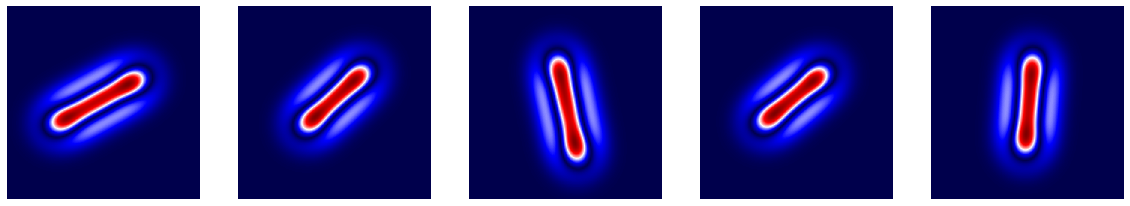

In [ ]:
show_images(images)

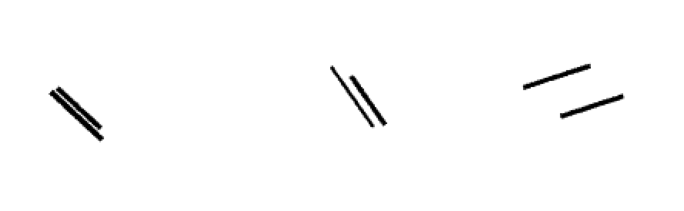

In [ ]:
show_images(indicator, cmap='binary')

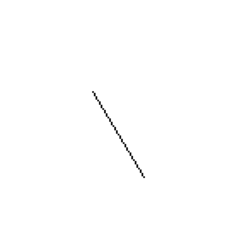

In [ ]:
image = np.zeros((128, 128), dtype=np.float32)

image = cv2.line(image, (50, 50), (80, 100), color=255, thickness=1)

show_images([image], cmap='binary')